# Lending Club Loan Data Analysis – Course-end Project 2
**Simplilearn Deep Learning | Predict loan default (2007–2015 historical data)**

**Objective:** Perform data preprocessing and build a deep learning model to predict whether a loan will default. Dataset is highly imbalanced.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


## 1. Load Data & Data Quality
Target: **not.fully.paid** (1 = default, 0 = repaid).

In [5]:
# Load dataset
df = pd.read_csv('loan_data.csv')
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Target distribution (not.fully.paid: 1=default, 0=repaid):")
print(df['not.fully.paid'].value_counts())
print("Missing values:")
print(df.isnull().sum())
df.head(10)

Shape: (9578, 14)
Columns: ['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']
Target distribution (not.fully.paid: 1=default, 0=repaid):
not.fully.paid
0    8045
1    1533
Name: count, dtype: int64
Missing values:
credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


## 2. Data Preprocessing
Encode categorical (purpose), fill missing if any, and prepare features.

In [8]:
# Target
y = df['not.fully.paid']
X_raw = df.drop(columns=['not.fully.paid'])
# Encode 'purpose' (categorical)
if 'purpose' in X_raw.columns:
    X_raw['purpose'] = LabelEncoder().fit_transform(X_raw['purpose'].astype(str))
# Fill any missing with column median
X_final = X_raw.fillna(X_raw.median(numeric_only=True))
# Ensure all numeric
X_final = X_final.select_dtypes(include=[np.number])
print("Feature matrix shape:", X_final.shape)
print("Missing:", X_final.isnull().sum().sum())

Feature matrix shape: (9578, 13)
Missing: 0


## 3. Train/Test Split, Scale, SMOTE
Stratified split, standardize, SMOTE on training set for class imbalance.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
# SMOTE (use k_neighbors <= min class count)
min_class = min((y_train == 0).sum(), (y_train == 1).sum())
k = min(5, min_class - 1) if min_class > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k)
X_train_bal, y_train_bal = smote.fit_resample(X_train_s, y_train)
print("After SMOTE - train labels:", pd.Series(y_train_bal).value_counts().to_dict())

After SMOTE - train labels: {0: 6436, 1: 6436}


## 4. Deep Learning Model
Feedforward network with Dense layers, Dropout, EarlyStopping.

In [14]:
n_features = X_train_bal.shape[1]
model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history = model.fit(X_train_bal, y_train_bal, validation_split=0.2, epochs=50, batch_size=256, callbacks=[early], verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.6483 - val_accuracy: 0.2730 - val_loss: 0.8707
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6494 - loss: 0.6261 - val_accuracy: 0.3060 - val_loss: 0.8592
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6533 - loss: 0.6190 - val_accuracy: 0.3336 - val_loss: 0.8510
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6546 - loss: 0.6167 - val_accuracy: 0.3437 - val_loss: 0.8459
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6586 - loss: 0.6134 - val_accuracy: 0.3728 - val_loss: 0.8143
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6600 - loss: 0.6090 - val_accuracy: 0.3518 - val_loss: 0.8450
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 - loss: 0.6112 - val_accuracy: 0.3515 - val_loss: 0.8454
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6616 - loss: 0.6100 - val_accuracy: 0.3616 - val_los

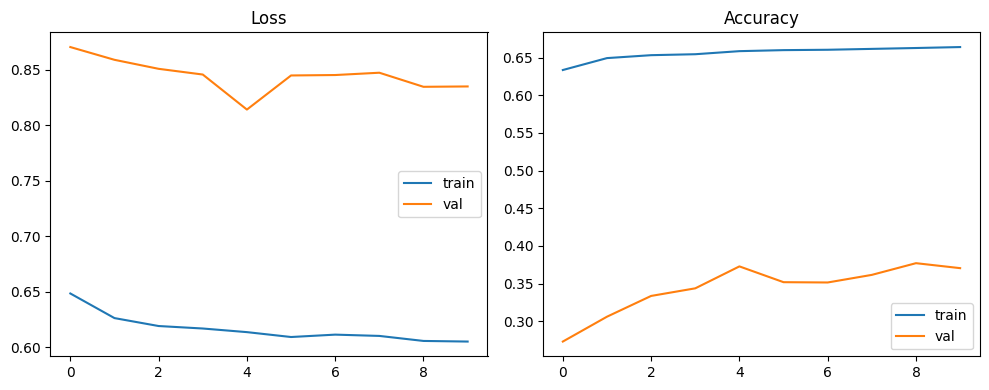

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

## 5. Evaluation on Test Set

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Accuracy: 0.7698
Precision: 0.3006
Recall: 0.329
F1-Score: 0.3142
ROC-AUC: 0.6738
\nClassification Report:
              precision    recall  f1-score   support

      Repaid       0.87      0.85      0.86      1609
     Default       0.30      0.33      0.31       307

    accuracy                           0.77      1916
   macro avg       0.59      0.59      0.59      1916
weighted avg       0.78      0.77      0.77      1916

Confusion Matrix:
[[1374  235]
 [ 206  101]]


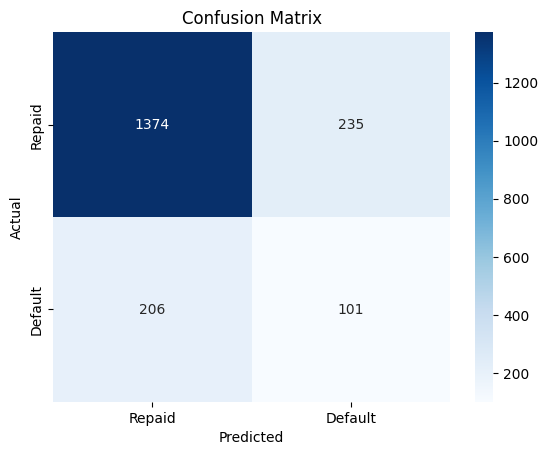

In [21]:
y_pred_proba = model.predict(X_test_s)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred, zero_division=0), 4))
print("F1-Score:", round(f1_score(y_test, y_pred, zero_division=0), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_proba), 4))
print("\\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Repaid', 'Default']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Repaid', 'Default'], yticklabels=['Repaid', 'Default'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()